In [2]:
%pip install tensorflow
%pip install lime
%pip install pandas
%pip install requests
%pip install plotly
%pip install shap
%pip install openpyxl
%pip install tinkoff-investments

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import Callback
from datetime import datetime, timedelta
from tinkoff.invest import Client, CandleInterval

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
tickers = [
  { "symbol": "BBG004730N88", "name": "Сбербанк" },
  { "symbol": "BBG004730RP0", "name": "Газпром" },
  { "symbol": "BBG004731032", "name": "Лукойл" },
  { "symbol": "BBG004S681W1", "name": "Норникель" },
  { "symbol": "BBG004S682Z6", "name": "Ростелеком" },
  { "symbol": "BBG004RVFCY3", "name": "Магнит" },
  { "symbol": "BBG004S683W7", "name": "Аэрофлот" },

  { "symbol": "BBG004RVFFC0", "name": "Татнефть" },
  { "symbol": "BBG004S68829", "name": "Татнефть - привилегированные акции" },
  { "symbol": "BBG004S68473", "name": "Интер РАО ЕЭС" },
  { "symbol": "BBG004S68598", "name": "Мечел" },
  { "symbol": "BBG00475K2X9", "name": "РусГидро" },
  { "symbol": "BBG002458LF8", "name": "Селигдар" },
  { "symbol": "TCS00A106YF0", "name": "ВК" },
  { "symbol": "BBG004730ZJ9", "name": "Банк ВТБ" },
  { "symbol": "BBG008F2T3T2", "name": "РУСАЛ" },
  { "symbol": "BBG000R04X57", "name": "Совкомфлот" },
  { "symbol": "TCS00A107ER5", "name": "Диасофт" },
  { "symbol": "BBG004S68B31", "name": "АЛРОСА" },
  { "symbol": "ISSUANCEMTSN", "name": "МТС" },
  { "symbol": "BBG00475KKY8", "name": "НОВАТЭК" },

  { "symbol": "BBG000RJL816", "name": "Таттелеком" },
  { "symbol": "BBG000Q7ZZY2", "name": "Объединенная авиастроительная корпорация" },
  { "symbol": "BBG0029SG1C1", "name": "Казаньоргсинтез - акции привилегированные" },
  { "symbol": "BBG004S689R0", "name": "ФосАгро" },
  { "symbol": "BBG000SK7JS5", "name": "Лензолото" },
  { "symbol": "TCS009086904", "name": "Славнефть" },
  { "symbol": "BBG004S68507", "name": "Магнитогорский металлургический комбинат" },
  { "symbol": "BBG004S686N0", "name": "Башнефть - привилегированные акции" },
  { "symbol": "BBG000VG1034", "name": "Россети Центр и Приволжье" },
  { "symbol": "TCS60A0JQ9P9", "name": "СПБ Биржа" },
  { "symbol": "TCS00A109B25", "name": "Озон Фармацевтика" },
  { "symbol": "BBG000RG4ZQ4", "name": "ТГК-14" },
  { "symbol": "BBG00475KHX6", "name": "Транснефть - привилегированные акции" },
  { "symbol": "TCS10A0JR6A6", "name": "РБК" },
  { "symbol": "BBG004S687G6", "name": "Россети Московский регион" },
  { "symbol": "BBG004S681M2", "name": "Сургутнефтегаз - привилегированные акции" },
  { "symbol": "TCS03A108X38", "name": "Корпоративный Центр Икс 5" },
  { "symbol": "BBG000BX7DH0", "name": "ТНС энерго Воронеж" },
  { "symbol": "TCS00A0JRH43", "name": "МТС-Банк" },
  { "symbol": "BBG004730JJ5", "name": "Московская Биржа" },
  { "symbol": "BBG004Z2RGW8", "name": "Русолово" },
  { "symbol": "BBG00Y91R9T3", "name": "Ozon Holdings PLC" },
  { "symbol": "BBG004S684M6", "name": "Газпром нефть" },
  { "symbol": "BBG004S688G4", "name": "Акрон" },
]

In [4]:
# Имитация данных пришедших с фронта
ticker = { "symbol": "BBG004730N88", "name": "Сбербанк" }
dateRange = { "start": "2025-01-21", "end": "2025-01-28" }

forecast_start_date = datetime.strptime(dateRange["start"], "%Y-%m-%d")
forecast_end_date = datetime.strptime(dateRange["end"], "%Y-%m-%d")

learning_start_date = datetime.strptime('2016-01-04', "%Y-%m-%d")
learning_end_date = forecast_start_date + timedelta(days=1)
forecast_days = (forecast_end_date - forecast_start_date).days

selected_macro = [  
	{ 'symbol': "panic_minus.xlsx", 'name': "Индекс паники отрицательный" },
  { 'symbol': "panic_plus.xlsx", 'name': "Индекс паники положительный" },
  #{ 'symbol': "panic_modal_sum.xlsx", 'name': "Индекс паники по модулю" },

  { 'symbol': "USD000UTSTOM", 'name': "Курс рубля к доллару" },
  #{ 'symbol': "BBG00YBCY3D8", 'name': "Цена на нефть Brent" },
  #{ 'symbol': "BBG000PLNQN7", 'name': "Цена на золото" },
  #{ 'symbol': "BBG00B3T3HD3", 'name': "Цена на сталь" },
  #{ 'symbol': "FUTCE1224000", 'name': "Цена на медь" },
  #{ 'symbol': "BBG004730JJ5", 'name': "Московская Биржа" },
  #{ 'symbol': "BBG004S681W1", 'name': "Норникель" },
  #{ 'symbol': "BBG004731354", 'name': "Роснефть" },
  #{ 'symbol': "BBG004730RP0", 'name': "Газпром" },
  #{ 'symbol': "BBG004RVFCY3", 'name': "Магнит" },
  #{ 'symbol': "BBG004730N88", 'name': "Сбербанк" },
  #{ 'symbol': "FUTNC0625000", 'name': "Цена на никель" },
  #{ 'symbol': "TCS9347Y8701", 'name': "Природный газ" },
  #{ 'symbol': "FUTRVI112200", 'name': "Индекс волатильности (VIX)" },
]
left_right_range = 30

In [5]:
# Системные настройки
epochs = 80
API_KEY  = "t.BtkoR-J4W1Zv_ZLwNySaplKK3BDC3NnDQk0RGbnx9U57uiREVKsVDYQbq7lasJzEFN4EwUtO7c_FtrJkCRhCag"

In [6]:
# Системная функция по нахождению FIGI(у tinkoff она своя)
def find_figi(ticker_names):
    figi_dict = {}
    with Client(API_KEY) as client:
        for name in ticker_names:
            try:
                response = client.instruments.find_instrument(query=name)
                if response.instruments:
                    figi_dict[name] = response.instruments[0].figi
                else:
                    figi_dict[name] = None
            except Exception as e:
                print(f"Ошибка при запросе FIGI для {name}: {e}")
                figi_dict[name] = None

    return figi_dict

tickers = ["VIX"]
figis = find_figi(tickers)

print("Не найдено FIGI для:", {k: v for k, v in figis.items() if v is None})
print("Найденные FIGI:", {k: v for k, v in figis.items() if v is not None})


Не найдено FIGI для: {}
Найденные FIGI: {'VIX': 'FUTRVI112200'}


In [7]:
# Сбор данных по акции

# Максимальный период запроса
max_period = timedelta(days=365)

def daterange(start_date, end_date, delta):
    """Генератор, который возвращает пары (период_начало, период_конец) для заданного диапазона."""
    current_start = start_date
    while current_start < end_date:
        current_end = min(current_start + delta, end_date)
        yield current_start, current_end
        current_start = current_end

all_candles = []

with Client(API_KEY) as client:
    for period_start, period_end in daterange(learning_start_date, learning_end_date, max_period):
        try:
            response = client.market_data.get_candles(
                figi=ticker['symbol'],
                from_=period_start,
                to=period_end,
                interval=CandleInterval.CANDLE_INTERVAL_DAY
            )
            if response.candles:
                all_candles.extend(response.candles)
            print(f"Получены свечи с {period_start} по {period_end}")
        except Exception as e:
            print(f"Ошибка при запросе свечей с {period_start} по {period_end}: {e}")

# Вывод в нужном формате
data = {
    candle.time.date(): candle.close.units + candle.close.nano / 1_000_000_000
    for candle in all_candles
}
stock_data = pd.DataFrame.from_dict(data, orient="index", columns=[ticker["name"]])
stock_data.index.name = "Date"

# Вывод как в `yf.download()`
print(stock_data)

Получены свечи с 2016-01-04 00:00:00 по 2017-01-03 00:00:00
Получены свечи с 2017-01-03 00:00:00 по 2018-01-03 00:00:00
Получены свечи с 2018-01-03 00:00:00 по 2019-01-03 00:00:00
Получены свечи с 2019-01-03 00:00:00 по 2020-01-03 00:00:00
Получены свечи с 2020-01-03 00:00:00 по 2021-01-02 00:00:00
Получены свечи с 2021-01-02 00:00:00 по 2022-01-02 00:00:00
Получены свечи с 2022-01-02 00:00:00 по 2023-01-02 00:00:00
Получены свечи с 2023-01-02 00:00:00 по 2024-01-02 00:00:00
Получены свечи с 2024-01-02 00:00:00 по 2025-01-01 00:00:00
Получены свечи с 2025-01-01 00:00:00 по 2025-01-22 00:00:00
            Сбербанк
Date                
2016-01-04     98.01
2016-01-05     98.89
2016-01-06     96.85
2016-01-07     96.85
2016-01-08     96.85
...              ...
2025-01-15    282.77
2025-01-16    281.80
2025-01-17    283.53
2025-01-20    278.19
2025-01-21    281.85

[2291 rows x 1 columns]


In [8]:
# Сбор данных по макро
def load_macro_data(selected_macro, learning_start_date, learning_end_date):
    max_period = timedelta(days=365)

    macro_data = {}
    
    def daterange(start_dt, end_dt, delta):
        """Генератор диапазонов дат для разбиения большого периода на части."""
        current_start = start_dt
        while current_start < end_dt:
            current_end = min(current_start + delta, end_dt)
            yield current_start, current_end
            current_start = current_end
    
    with Client(API_KEY) as client:
        for macro in selected_macro:
            name = macro["name"]
            symbol = macro["symbol"]
            if symbol.endswith(".xlsx"):
                # Чтение данных из Excel-файла (панические индексы)
                try:
                    panic_data = pd.read_excel(symbol)
                    panic_data.reset_index(inplace=True)
                    panic_data.set_index("Date", inplace=True)
                    panic_data.drop(columns=["index"], inplace=True, errors='ignore')
                    series = panic_data.squeeze()
                    series.name = name
                    macro_data[name] = series
                except Exception as e:
                    print(f"Ошибка при чтении файла {symbol} для {name}: {e}")
            else:
                # Сбор данных через Tinkoff Invest API
                all_candles = []
                for period_start, period_end in daterange(learning_start_date, learning_end_date, max_period):
                    try:
                        response = client.market_data.get_candles(
                            figi=symbol,
                            from_=period_start,
                            to=period_end,
                            interval=CandleInterval.CANDLE_INTERVAL_DAY
                        )
                        if response.candles:
                            all_candles.extend(response.candles)
                    except Exception as e:
                        print(f"Ошибка при запросе {name} с {period_start} по {period_end}: {e}")
                # Формирование Series: индекс — дата, значение — цена закрытия
                # Если API возвращает тип time с часовым поясом, извлекаем дату
                data = {}
                for candle in all_candles:
                    # Получаем дату из candle.time (например, методом .date())
                    date_key = candle.time.date()
                    # Считаем цену закрытия как сумму единиц и наносекунд (если требуется)
                    price = candle.close.units + candle.close.nano / 1_000_000_000
                    data[date_key] = price
                if data:
                    series = pd.Series(data, name=name)
                    macro_data[name] = series
                else:
                    print(f"Нет данных для {name} за указанный период.")
    
    # Преобразуем все Series в macro_data к datetime64 перед объединением
    for key in macro_data:
        macro_data[key].index = pd.to_datetime(macro_data[key].index)
    # Объединяем данные в DataFrame
    macro_df = pd.DataFrame(macro_data)

    macro_df.index = pd.to_datetime(macro_df.index)
    macro_df.index.name = "Date"

    return macro_df

In [23]:
# Сбор данных по макроиндикаторам
macro_data = load_macro_data(selected_macro, learning_start_date, learning_end_date)

# Определяем столбцы, пропуски в которых не надо заменять
exclude_columns = {"Индекс паники отрицательный", "Индекс паники положительный", "Индекс паники по модулю"}

# Заполняем NaN средними значениями только для нужных столбцов
for col in macro_data.columns:
    if col not in exclude_columns:
        macro_data[col].fillna(macro_data[col].mean(), inplace=True)

print(macro_data)

macro_data = macro_data.dropna(how='any')

            Индекс паники отрицательный  Индекс паники положительный  \
Date                                                                   
2016-01-04                   -71.780689                   772.292071   
2016-01-05                          NaN                          NaN   
2016-01-06                          NaN                          NaN   
2016-01-11                   -65.696080                   772.125372   
2016-01-12                          NaN                          NaN   
...                                 ...                          ...   
2025-01-17                          NaN                          NaN   
2025-01-18                          NaN                          NaN   
2025-01-20                  -155.540582                   476.726187   
2025-01-21                          NaN                          NaN   
2025-01-27                  -142.066519                   499.520228   

            Курс рубля к доллару  
Date                        

C:\Users\Roman\AppData\Local\Temp\ipykernel_16060\1678716026.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  macro_data[col].fillna(macro_data[col].mean(), inplace=True)


In [19]:
# Объединяем с макроэкономическими данными
df = pd.concat([stock_data, macro_data], axis=1).dropna()
df

,Сбербанк,Индекс паники отрицательный,Индекс паники положительный,Курс рубля к доллару
Date,,,,
2016-01-04,98.01,-71.780689,772.292071,73.1688
2016-01-11,91.03,-65.696080,772.125372,76.2061
2016-01-18,86.15,-68.930493,761.513712,79.2947
2016-01-25,91.00,-88.228530,692.523423,80.0635
2016-02-01,96.50,-97.866305,643.465573,77.3110
...,...,...,...,...
2024-05-13,314.85,-240.853002,409.799779,91.3525
2024-05-20,321.08,-226.888686,445.297801,90.7500
2024-05-27,317.09,-229.027596,448.270083,88.6200


In [11]:
class StopOnValLossIncreaseOrThreshold(Callback):
    def __init__(self, patience=3, val_loss_threshold=0.002):
        super(StopOnValLossIncreaseOrThreshold, self).__init__()
        self.patience = patience
        self.val_loss_threshold = val_loss_threshold
        self.val_losses = []  # Список для хранения значений val_loss
        self.losses = []      # Список для хранения значений loss
        self.counter = 0      # Счетчик, сколько эпох подряд val_loss увеличивается

    def on_epoch_end(self, epoch, logs=None):
        # Получаем значения loss и val_loss для текущей эпохи
        loss = logs.get('loss')
        val_loss = logs.get('val_loss')

        # Проверка на выполнение условия по threshold для val_loss
        if val_loss < self.val_loss_threshold:
            print(f"\nStopping early because val_loss reached below {self.val_loss_threshold}.")
            self.model.stop_training = True
            return

        # Если val_loss увеличивается, а loss уменьшается, увеличиваем счетчик
        if len(self.val_losses) > 0:
            if val_loss > self.val_losses[-1] and loss < self.losses[-1]:
                self.counter += 1
            else:
                self.counter = 0

        # Добавляем текущие значения в списки
        self.val_losses.append(val_loss)
        self.losses.append(loss)

        # Если счетчик достиг значения patience, прекращаем обучение
        if self.counter >= self.patience:
            print(f'\nStopping early as val_loss increased while loss decreased for {self.patience} epochs.')
            self.model.stop_training = True


In [12]:
# Нормализация данных
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df.values)
print(forecast_days)

7


Epoch 1/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 375ms/step - loss: 0.0974 - val_loss: 0.1571
Epoch 2/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0199 - val_loss: 0.0429
Epoch 3/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.0065 - val_loss: 0.0151
Epoch 4/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.0144 - val_loss: 0.0200
Epoch 5/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0047 - val_loss: 0.0361
Epoch 6/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0056 - val_loss: 0.0532
Epoch 7/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0044 - val_loss: 0.0579
Epoch 8/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0052 - val_loss: 0.0525
Epoch 9/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.0031 - val_loss: 0.0430
Epoch 10/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.0028 - val_loss: 0.0346
Epoch 11/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.0038 - val_loss: 0.0285
Epoch 12/80
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.0038 - val_lo

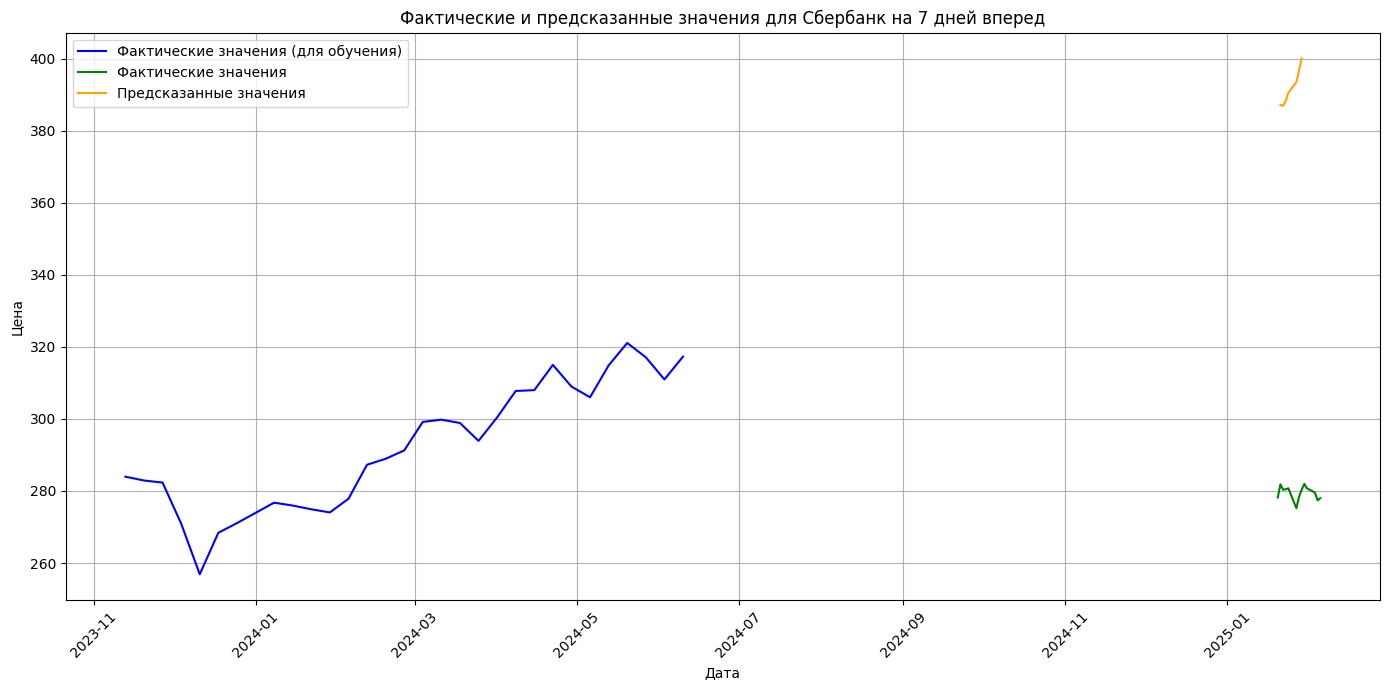

In [13]:
# Создание тренировочного набора данных
look_back = 60
train_size = int(len(data_scaled) * 0.70)
train_data = data_scaled[:train_size]

# Создание функции для генерации обучающих данных
def create_dataset(data, look_back):
    x, y = [], []
    for i in range(look_back, len(data)):
        x.append(data[i-look_back:i, :])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

# Обучение начальной модели
x_train, y_train = create_dataset(train_data, look_back)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

# Создание и обучение модели
model = Sequential([
    Input(shape=(x_train.shape[1], x_train.shape[2])),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

# Компиляция модели
model.compile(optimizer='adam', loss='mean_squared_error')

# Создаем экземпляр нашего callback
early_stopping = StopOnValLossIncreaseOrThreshold(patience=3)

# Обучение модели с использованием кастомного callback
model.fit(x_train, y_train, epochs=epochs, batch_size=8, validation_split=0.9, callbacks=[early_stopping])

# Прогнозирование на следующий месяц
predictions = []
last_window = data_scaled[-look_back:]  # Получаем последние 60 дней данных

for _ in range(forecast_days):  # Прогнозирование на forecast_days дней вперед
    # Подготовка данных для предсказания
    current_input = last_window.reshape(1, look_back, x_train.shape[2])

    # Получение предсказания
    prediction = model.predict(current_input, verbose=0)
    predictions.append(prediction[0][0])

    # Создаем новую строку данных с предсказанным значением
    # Предполагаем, что у нас есть все признаки. Копируем последнюю строку
    new_row = last_window[-1:].copy()
    new_row[0, 0] = prediction[0][0]  # Обновляем только предсказанное значение

    # Обновляем окно данных, удаляя первую строку и добавляя новое предсказание
    last_window = np.vstack((last_window[1:], new_row))

# Обратное преобразование предсказанных значений
predictions = np.array(predictions).reshape(-1, 1)
predictions_original_scale = scaler.inverse_transform(
    np.hstack([predictions, np.zeros((len(predictions), x_train.shape[2]-1))])
)[:, 0]

# Загрузка фактических данных
forecast_end_extended = forecast_end_date + timedelta(days=left_right_range)
all_actual_candles = []

with Client(API_KEY) as client:
    for period_start, period_end in daterange(forecast_start_date, forecast_end_extended, max_period):
        try:
            response = client.market_data.get_candles(
                figi=ticker['symbol'],
                from_=period_start,
                to=period_end,
                interval=CandleInterval.CANDLE_INTERVAL_DAY
            )
            if response.candles:
                all_actual_candles.extend(response.candles)
            print(f"Получены свечи с {period_start} по {period_end}")
        except Exception as e:
            print(f"Ошибка при запросе свечей с {period_start} по {period_end}: {e}")

actual_data = {
    candle.time.date(): candle.close.units + candle.close.nano / 1_000_000_000
    for candle in all_actual_candles
}

actual_df = pd.DataFrame.from_dict(actual_data, orient="index", columns=[ticker["name"]])
actual_df.index.name = "Date"

ticker_name = ticker['name']
actual_prices = actual_df[ticker_name].values

# Построение графика
plt.figure(figsize=(14, 7))
# Фактические значения на графике (последние 15)
plt.plot(df.index[-left_right_range:], df[ticker_name].iloc[-left_right_range:], label='Фактические значения (для обучения)', color='blue')
# Фактические данные для периода 2021-11-01 по 2021-12-01
plt.plot(actual_df.index, actual_prices, label='Фактические значения', color='green')

# Предсказанные значения на графике
forecast_dates = pd.date_range(start=forecast_start_date, periods=forecast_days, freq='B')
plt.plot(forecast_dates, predictions_original_scale, label='Предсказанные значения', color='orange')

plt.title(f'Фактические и предсказанные значения для {ticker_name} на {forecast_days} дней вперед')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

val_loss_prev = float('inf')  # Инициализация предыдущей ошибки валидации

In [14]:
print('actual_prices', actual_prices)
#print('============================================')
print('predictions_original_scale', predictions_original_scale)


actual_prices [278.19 281.85 280.36 280.49 280.74 275.23 278.35 280.36 281.97 280.73
 279.55 277.4  278.01]
predictions_original_scale [387.12546987 386.89012736 388.22006947 390.53234825 393.42674847
 396.65013947 400.04134991]


In [15]:
# Начальное и конечное значение
initial_value = predictions_original_scale[0]
final_value = predictions_original_scale[-1]

# Расчет процентного падения
percentage_drop = ((initial_value - final_value) / initial_value) * 100
print(initial_value, final_value)
print(f"Падение составило {percentage_drop:.2f}%")

387.12546986937525 400.0413499116898
Падение составило -3.34%


In [16]:
# Получаем текущую дату и время в формате 'YYYY-MM-DD_HH-MM-SS'
#current_datetime = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# Указываем путь для сохранения модели с датой и временем
#model_file"name" = f"model_{current_datetime}.keras"

# Сохраняем модель
#model.save(model_file"name")

#print(f"Модель сохранена как {model_file"name"}")

In [17]:
# Загружаем модель
#model_file"name" = "model_2025-01-25_15-52-34.keras"  # Укажите имя файла вашей модели
#model = load_model(model_file"name")


# Прогнозирование на следующий месяц 30 раз и усреднение результатов
num_predictions = 1
all_predictions = []

# Повторяем прогнозирование 30 раз
for _ in range(num_predictions):
    predictions = []
    last_window = data_scaled[-look_back:]  # Получаем последние 60 дней данных

    for day in range(forecast_days):  # Прогнозирование на forecast_days дней вперед
        # Подготовка данных для предсказания
        current_input = last_window.reshape(1, look_back, x_train.shape[2])

        # Получение предсказания
        prediction = model.predict(current_input, verbose=0)
        predictions.append(prediction[0][0])

        # Создаем новую строку данных с предсказанным значением
        new_row = last_window[-1:].copy()
        new_row[0, 0] = prediction[0][0]  # Обновляем только предсказанное значение

        # Обновляем окно данных, удаляя первую строку и добавляя новое предсказание
        last_window = np.vstack((last_window[1:], new_row))

        # Только иногда дообучаем модель (например, после каждых 5 предсказаний)
        #if day % 2 == 0:
            #x_new = last_window[:-1].reshape(1, look_back - 1, x_train.shape[2])
            #y_new = np.array([prediction[0][0]])
            #model.fit(x_new, y_new, epochs=1, batch_size=1, verbose=0)

    # Добавляем предсказания для этого запуска в общий список
    all_predictions.append(predictions)

# Преобразуем все предсказания в массив NumPy
all_predictions = np.array(all_predictions)

# Усреднение по каждому дню
average_predictions = np.mean(all_predictions, axis=0)

# Обратное преобразование предсказанных значений
average_predictions = average_predictions.reshape(-1, 1)
predictions_original_scale = scaler.inverse_transform(
    np.hstack([average_predictions, np.zeros((len(average_predictions), x_train.shape[2] - 1))])
)[:, 0]

predictions_original_scale +=74

# Загрузка фактических данных с end_date - 60 до end_date
training_end_date = pd.to_datetime(end_date) - pd.Timedelta(days=60)
training_data = df.loc[training_end_date:end_date]

# Загрузка фактических данных с end_date до end_date + 30
fact_data = pd.to_datetime(end_date) - pd.Timedelta(days=1)
fact_data_end = fact_data + pd.Timedelta(days=30)

actual_data = yf.download(ticker, start=fact_data, end=fact_data_end)
actual_prices = actual_data['Close'].values

# Построение графика
plt.figure(figsize=(14, 7))

# Фактические значения на графике
plt.plot(training_data.index, training_data['Close'], label='Фактические значения (для обучения)', color='blue')
print("training_data", training_data)

# Фактические данные для периода 2021-11-01 по 2021-12-01
plt.plot(actual_data.index, actual_prices, label='Фактические значения', color='green')

# Усредненные предсказания на графике
forecast_dates = pd.date_range(start=pd.to_datetime(end_date) - pd.Timedelta(days=1), periods=forecast_days, freq='B')
plt.plot(forecast_dates, predictions_original_scale, label='Средние предсказания', color='orange')
print(forecast_dates)

plt.title(f'Фактические и средние предсказанные значения для {ticker_name}')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'end_date' is not defined

In [ ]:
def manual_feature_importance(model, x_train, feature_"name"s):
    # Проверяем, что x_train имеет 3 измерения (samples, timesteps, features)
    if x_train.ndim != 3:
        raise ValueError("Expected x_train to have 3 dimensions (samples, timesteps, features)")

    n_samples, n_timesteps, n_features = x_train.shape

    # Проверяем, что количество feature_"name"s совпадает с количеством признаков в x_train
    if len(feature_"name"s) != n_features:
        raise ValueError(
            f"Mismatch between number of features in x_train ({n_features}) "
            f"and length of feature_"name"s ({len(feature_"name"s)})"
        )

    # Используем веса модели для оценки важности признаков
    if hasattr(model.layers[0], 'get_weights'):
        # Получаем веса из первого слоя модели
        weights = model.layers[0].get_weights()[0]  # Форма (input_dim, units)

        # Рассчитываем важность признаков на основе средних абсолютных значений весов
        feature_importance = np.abs(weights).mean(axis=1)  # Форма (input_dim,)

        # Проверяем соответствие длины feature_importance количеству признаков
        if len(feature_importance) != n_features:
            raise ValueError(
                f"Mismatch between calculated feature importance ({len(feature_importance)}) "
                f"and number of features ({n_features})"
            )

        # Создаем DataFrame с важностью признаков
        importance_df = pd.DataFrame({
            'feature': feature_"name"s,
            'importance': feature_importance
        }).sort_values('importance', ascending=False)

        # Построение графика важности
        plt.figure(figsize=(10, 6))
        plt.bar(importance_df['feature'], importance_df['importance'], color='skyblue')
        plt.title('Feature Importance')
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        return importance_df
    else:
        raise ValueError("Cannot extract feature importance from this model type")

# Пример использования
feature_importance = manual_feature_importance(model, x_train, df.columns)
print(feature_importance)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lime import lime_tabular

# Преобразуем 3D данные модели в 2D для анализа с LIME
reshaped_x_train = x_train.reshape(x_train.shape[0], -1)  # Преобразуем (samples, timesteps, features) в 2D
reshaped_test = x_train[:10].reshape(10, -1)  # Берем первые 10 примеров для анализа

num_features = reshaped_x_train.shape[1]  # Общее количество признаков
generated_feature_"name"s = [f"{"name"}_t{t}" for t in range(x_train.shape[1]) for "name" in df.columns]
print(f"Expected {num_features} features, generated {len(generated_feature_"name"s)} feature "name"s")

# Убедимся, что размерности совпадают
assert reshaped_x_train.shape[1] == x_train.shape[1] * x_train.shape[2], "Ошибка в преобразовании размерности"

# Адаптация функции предсказания
def predict_fn(data):
    """
    Преобразует входные данные из 2D обратно в 3D для модели и возвращает предсказания.
    """
    # Преобразуем данные обратно в 3D
    reshaped_data = data.reshape(data.shape[0], x_train.shape[1], x_train.shape[2])
    # Получаем предсказания
    predictions = model.predict(reshaped_data, verbose=0)
    # Возвращаем предсказания в виде плоского массива
    return predictions.flatten()

# Создаём LIME объяснитель
explainer = lime_tabular.LimeTabularExplainer(
    training_data=reshaped_x_train,       # Данные для обучения объяснителя
    feature_"name"s=[f"{"name"}_t{t}" for t in range(x_train.shape[1]) for "name" in df.columns],  # Генерация имен признаков
    mode="regression",                   # Режим регрессии
    verbose=True,
    random_state=42
)

# Анализ конкретного примера
example_idx = 0  # Индекс строки для анализа
reshaped_example = reshaped_test[example_idx]  # Один пример из тестового набора

# Получаем объяснение для конкретного примера
exp = explainer.explain_instance(
    reshaped_example,
    predict_fn,  # Используем адаптированную функцию предсказания
    num_features=12  # Количество признаков для визуализации
)

# Выводим интерпретацию
exp.show_in_notebook()

# Альтернативно, можно сохранить результат в HTML
exp.save_to_file("lime_explanation.html")

# Дополнительно: построение важности признаков
# Извлекаем важность из объяснения
feature_importance = exp.as_list()  # Список [(feature_"name", importance), ...]

# Преобразуем в DataFrame для визуализации
importance_df = pd.DataFrame(feature_importance, columns=["feature", "importance"])
importance_df["absolute_importance"] = importance_df["importance"].abs()
importance_df = importance_df.sort_values("absolute_importance", ascending=False)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.bar(importance_df["feature"], importance_df["absolute_importance"], color="skyblue")
plt.title("Feature Importance (LIME)")
plt.xlabel("Features")
plt.ylabel("Absolute Importance")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
pip install tslearn
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.metrics import dtw

# --- 1. Подготовка данных ---
# Пример данных: временные ряды макрофакторов
# Предположим, что df содержит временные ряды макрофакторов
# Колонки - факторы, строки - временные метки
np.random.seed(42)
dates = pd.date_range("2020-01-01", periods=200)
factors = ["usd_to_rub", "oil_price", "gold_price", "sp500", "mos_index"]
data = np.random.rand(len(dates), len(factors)) * 100

# Преобразуем в DataFrame
df = pd.DataFrame(data, index=dates, columns=factors)

# Нормализация данных для работы с tslearn
#scaler = TimeSeriesScalerMinMax(value_range=(0, 1))  # Нормализация данных
time_series_data = scaler.fit_transform(df.values.T)  # Преобразуем данные в формат tslearn
print(f"Форма данных для tslearn: {time_series_data.shape}")

# --- 2. Кластеризация временных рядов ---
n_clusters = 3  # Задаем количество кластеров
#model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42)
labels = model.fit_predict(time_series_data)

# --- 3. Визуализация кластеров ---
plt.figure(figsize=(10, 6))
for cluster_idx in range(n_clusters):
    cluster_data = time_series_data[labels == cluster_idx]
    for series in cluster_data:
        plt.plot(series.flatten(), alpha=0.5)
    plt.plot(model.cluster_centers_[cluster_idx].flatten(), label=f"Кластер {cluster_idx}", linewidth=3)

plt.title("Кластеры временных рядов макрофакторов")
plt.xlabel("Временные шаги")
plt.ylabel("Нормализованное значение")
plt.legend()
plt.tight_layout()
plt.show()

# --- 4. Анализ результатов ---
# Добавим метки кластеров в DataFrame
cluster_labels = pd.DataFrame({"Factor": factors, "Cluster": labels})
print("Кластеризация макрофакторов:")
print(cluster_labels)

# Дополнительно: расчет расстояний DTW между временными рядами
dist_matrix = np.zeros((len(factors), len(factors)))
for i in range(len(factors)):
    for j in range(len(factors)):
        dist_matrix[i, j] = dtw(time_series_data[i], time_series_data[j])

dist_df = pd.DataFrame(dist_matrix, index=factors, columns=factors)
print("Матрица расстояний DTW:")
print(dist_df)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

def sensitivity_analysis(model, x_test, feature_"name"s, n_samples=10, perturbation=0.1):
    """
    Выполняет анализ чувствительности для модели LSTM, изменяя один макрофактор.

    model - обученная модель LSTM.
    x_test - тестовые данные (3D).
    feature_"name"s - имена признаков.
    n_samples - количество примеров для анализа.
    perturbation - величина изменения признака.
    """
    # Получаем базовые предсказания для первых n_samples
    base_predictions = model.predict(x_test[:n_samples], verbose=0)

    # Список для хранения изменений в предсказаниях
    sensitivity_changes = []

    # Анализируем влияние каждого признака
    for feature_idx, feature_"name" in enumerate(feature_"name"s):
        feature_changes = []

        for i in range(n_samples):
            perturbed_data = x_test[:n_samples].copy()

            # Изменяем значение одного признака для конкретного примера
            perturbed_data[i, :, feature_idx] += perturbation  # Увеличиваем значение признака

            # Получаем новое предсказание
            new_prediction = model.predict(perturbed_data, verbose=0)

            # Измеряем разницу в предсказаниях
            change_in_prediction = np.abs(new_prediction - base_predictions[i])
            feature_changes.append(change_in_prediction[0][0])  # Сохраняем разницу для одного примера

        # Рассчитываем среднее изменение для этого признака
        sensitivity_changes.append(np.mean(feature_changes))

    # Создаем DataFrame с результатами
    sensitivity_df = pd.DataFrame({
        'Feature': feature_"name"s,
        'Sensitivity': sensitivity_changes
    })

    # Сортируем по чувствительности
    sensitivity_df = sensitivity_df.sort_values('Sensitivity', ascending=False)

    # Визуализируем результат
    plt.figure(figsize=(10, 6))
    plt.bar(sensitivity_df['Feature'], sensitivity_df['Sensitivity'], color='skyblue')
    plt.title('Sensitivity Analysis (Impact of Features on Prediction)')
    plt.xlabel('Features')
    plt.ylabel('Sensitivity (Change in Prediction)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return sensitivity_df

# Пример использования
x_test = data_scaled[-30:]  # Используем последние 30 примеров из набора данных для теста
feature_"name"s = [f'Feature_{i}' for i in range(x_test.shape[2])]  # Замените на реальные имена признаков
sensitivity_df = sensitivity_analysis(model, x_test, feature_"name"s, n_samples=10, perturbation=0.1)
print(sensitivity_df)
